In [98]:
from spyral.core.constants import QBRHO_2_P
from spyral.core.run_stacks import form_run_string

from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.target import GasTarget, load_target
from spyral_utils.plot import Histogrammer

from pathlib import Path
from scipy.constants import physical_constants, torr
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import vector

%matplotlib widget

In [99]:
# Load config
workspace_path = Path("D:\\dv_new")
solver_result_path = workspace_path / "InterpSolver"
target_material_path = Path("C:\\Users\\zachs\\Desktop\\e20009_analysis\\e20009_analysis\\e20009_parameters\\e20009_target.json")
beam_events_path = workspace_path / "beam_events"

# Run number range (inclusive)
run_min = 108
run_max = 366

# The nucleus we observe (the one fitted)
ejectile_z = 1
ejectile_a = 1

# The incoming nucleus (the beam)
projectile_z = 4
projectile_a = 10

# The target nucleus
target_z = 1
target_a = 2

residual_z = target_z + projectile_z - ejectile_z
residual_a = target_a + projectile_a - ejectile_a

if residual_z < 0:
    raise Exception(f"Illegal nuclei! Residual Z: {residual_z}")
if residual_a < 1:
    raise Exception(f"Illegal nuclei! Residual A: {residual_a}")

In [100]:
# Setup nuclear data objects
nuclear_map = NuclearDataMap()

target_material = load_target(target_material_path, nuclear_map)
if not isinstance(target_material, GasTarget):
    print('Target error!')

ejectile = nuclear_map.get_data(ejectile_z, ejectile_a)
projectile = nuclear_map.get_data(projectile_z, projectile_a)
target = nuclear_map.get_data(target_z, target_a)
residual = nuclear_map.get_data(residual_z, residual_a)

# Initial beam energy
proj_energy_start = 93.0 #MeV

In [101]:
# Define parameters used for analysis
max_z = 0.960    # Units of meters. Maximum z value of vertex
min_z = 0.005    # Units of meters. Minimum z value of vertex



boltzmann = physical_constants["Boltzmann constant"][0]    # Units of Joules / Kelvin
torr_2_pascal = torr    # Convert from torr to pascals
pressure = 600 # Units of Torr
temperature = 273.15    # Units of Kelvin, STP


In [102]:
# Create histograms 
grammer = Histogrammer()
grammer.add_hist2d('ke_theta', (360, 800), ((0.0, 180.0), (0.0, 40.0)))
grammer.add_hist2d('ke_phi', (360, 1600), ((0.0, 360.0), (0.0, 80.0)))
grammer.add_hist1d('ex',100, (-1.0, 4.0))
grammer.add_hist1d('chisq', 2000, (0.0, 1.0e-3))
grammer.add_hist1d("cm_polar", 45, (0.0, 90.0))
grammer.add_hist1d('beam_events_ic', 4096, (0.0, 4096.0))
grammer.add_hist1d('sim_lab_polar', 18, (0.0, 90.0))
grammer.add_hist2d('chi_polar', (180, 500), ((0.0, 180.0), (0.0, 10e-5)))
grammer.add_hist1d('z_vert', 1000, (-0.1, 1.1))

In [103]:
# Do analysis of events
kinetics = np.empty(0, float)
angles = np.empty(0, float)
chisq = np.empty(0, float)
target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})

for run in range(run_min, run_max+1):
    df = None
    try:
        path = solver_result_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue

    # Apply gates to data
    df = (df.filter((pl.col('redchisq') < 5e-5)
                   & (pl.col("vertex_z") > min_z) 
                   & (pl.col("vertex_z") < max_z)
                   #&(pl.col('brho') <25)
                   #& (pl.col("brho") >= 0.25)
                   #& (pl.col('polar') >= np.deg2rad(70))
                   #& (pl.col('polar') <= np.deg2rad(85))
                   )
            .sort("polar", descending=True)
            .unique("event", keep="first")
    )

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Get reduced chi-squared information
    cs = df.select('redchisq').to_numpy().flatten()

    # Get vertex z position
    zvert=df.select('vertex_z').to_numpy().flatten()
    grammer.fill_hist1d('z_vert', zvert)

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # # Gate excitation spectrum on CM angle
    mask_ex = (np.deg2rad(0.0) <= cm_polar) & (cm_polar < np.deg2rad(38.0))
    ex_energy_gated = ex_energy[mask_ex]

    # Select excited state to look at its angular distribution
    mask_cm = (3.1 <= ex_energy) & (ex_energy < 3.6)
    cm_polar_gated = cm_polar[mask_cm]

    # Fill histograms and arrays
    grammer.fill_hist2d('ke_theta', np.rad2deg(polar), kinetic_energy)
    grammer.fill_hist2d('ke_phi', np.rad2deg(az), kinetic_energy)
    grammer.fill_hist1d('ex', ex_energy_gated)
    grammer.fill_hist1d("cm_polar", np.rad2deg(cm_polar_gated))
    grammer.fill_hist1d("chisq", cs)
    grammer.fill_hist2d('chi_polar', np.rad2deg(polar), cs)
    kinetics = np.append(kinetics, kinetic_energy)
    angles = np.append(angles, np.rad2deg(polar))
    chisq = np.append(chisq, cs)

print(f"Median chisq: {np.median(chisq)}")

Median chisq: 8.965203069450383e-06


Text(0, 0.5, 'Counts')

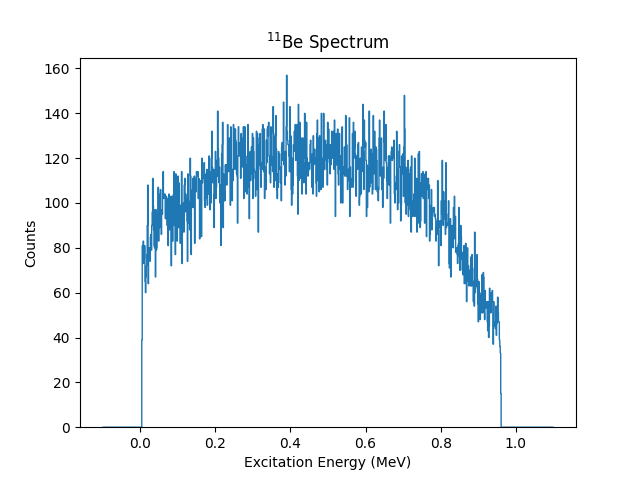

In [104]:
# Plot residual excitation energy spectrum
vertz = grammer.get_hist1d("z_vert")
fig, ax = plt.subplots(1,1)
ax.stairs(vertz.counts, edges=vertz.bins)
ax.set_title(f"{residual.get_latex_rep()} Spectrum")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")

In [105]:
# Perform analysis of beam events
for run in range(run_min, run_max+1):
    df = None
    try:
        path = beam_events_path / f"{form_run_string(run)}.parquet"
        df = pl.read_parquet(path)
    except Exception:
        continue

    # Apply gates to beam events
    # df = df.filter(\
    #                (pl.col('ic_multiplicity') == 1)
    #                & (pl.col('ic_sca_multiplicity') == 1) 
    #                #& (pl.col('ic_centroid') < 68)
    #                #& (abs(pl.col('ic_sca_multiplicity') - pl.col('ic_multiplicity')) <= 1)
    #                )

    ic_amp = df.select(pl.col('ic_amplitude').list.explode()).to_numpy().flatten()
    
    grammer.fill_hist1d('beam_events_ic', ic_amp)

In [106]:
# # Perform analysis of simulated state
# sim_data = h5.File('/Volumes/e20009/h5new/run_0100.h5', "r")
# meta_group = sim_data.get("meta")
# meta_data = meta_group.get("meta")  # type: ignore
# min_event = int(meta_data[0])
# max_event = int(meta_data[2])

# input_lab_polar = []
# for event in range(min_event, max_event + 1):
#     input_group = sim_data.get('input')
#     event_input = input_group.get(f"evt{event}_input")
#     input_lab_polar.append(event_input[6])

# grammer.fill_hist1d('sim_lab_polar', np.asarray(input_lab_polar))

In [107]:
# # Plot residual excitation energy spectrum
# sim_lab_polar = grammer.get_hist1d("sim_lab_polar")
# fig, ax = plt.subplots(1,1)
# ax.stairs(sim_lab_polar.counts, edges=sim_lab_polar.bins)
# ax.set_title(f"{residual.get_latex_rep()} Spectrum")
# ax.set_xlabel("Lab polar angle (degrees)")
# ax.set_ylabel("Counts")

In [108]:
# Calculate kinematics for residual particle in some state with given energy
ex = 1.78

angle_range = np.linspace(0., np.pi, 1000)

Q = projectile.mass + target.mass - (ejectile.mass + residual.mass + ex)
term1 = np.sqrt(projectile.mass * ejectile.mass * proj_energy_start) / (ejectile.mass + residual.mass) * np.cos(angle_range)
term2 = (proj_energy_start * (residual.mass - projectile.mass) + residual.mass*Q) / (residual.mass + ejectile.mass)
eject_energy = term1 + np.sqrt(term1*term1 + term2)
eject_energy = eject_energy**2.0

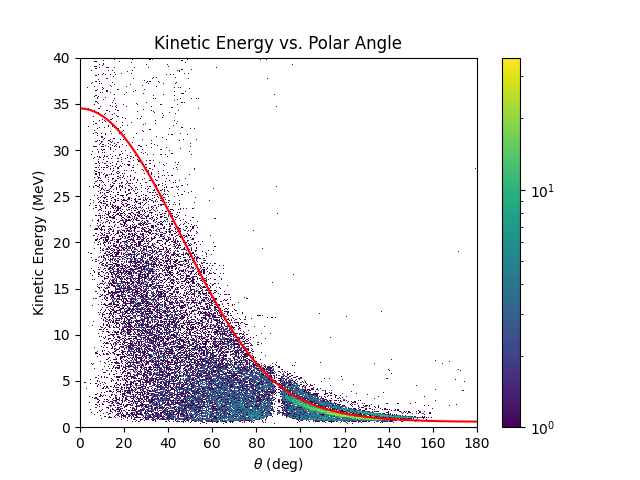

In [109]:
# Plot kinematics from data and compare with theoretical kinematics
ke_theta = grammer.get_hist2d("ke_theta")
ke_phi = grammer.get_hist2d("ke_phi")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(ke_theta.x_bins, ke_theta.y_bins, ke_theta.counts, norm="log")
ax.set_title("Kinetic Energy vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Kinetic Energy (MeV)")
fig.colorbar(mesh, ax=ax)
ax.plot(np.rad2deg(angle_range), eject_energy, color='red')

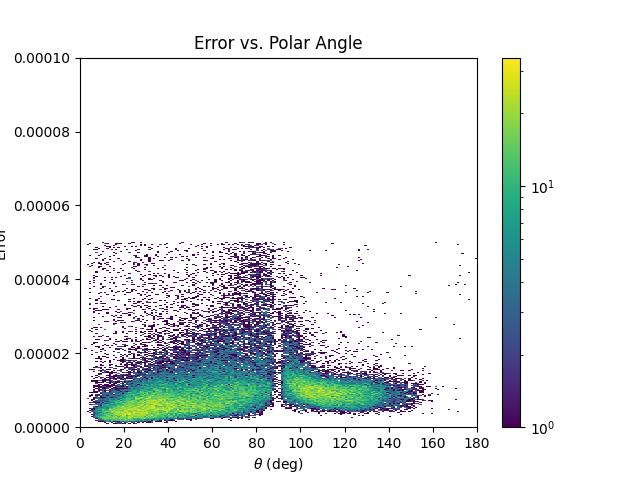

In [110]:
# Plot chi-squared vs lab polar angle
chi_polar = grammer.get_hist2d("chi_polar")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(chi_polar.x_bins, chi_polar.y_bins, chi_polar.counts, norm='log')
ax.set_title("Error vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Error")
fig.colorbar(mesh, ax=ax)

Text(0, 0.5, 'Counts')

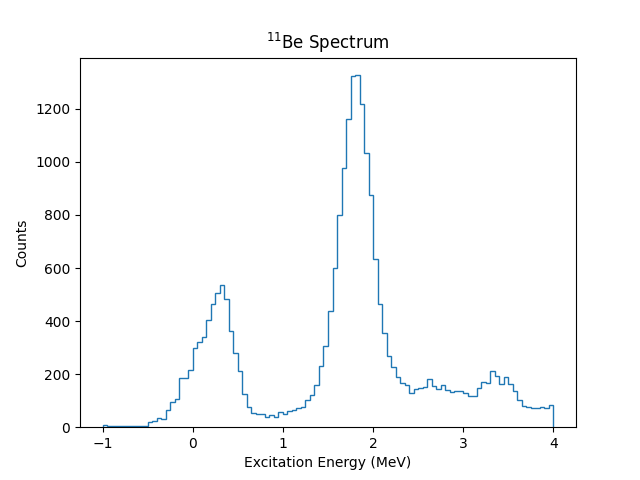

In [111]:
# Plot residual excitation energy spectrum
ex_hist = grammer.get_hist1d("ex")
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Spectrum")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")

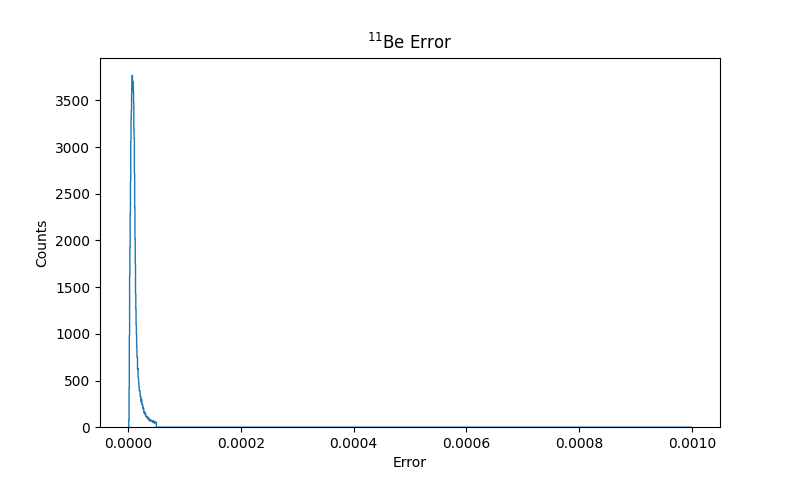

In [112]:
# Plot reduced chi-squared of fits to data
hist = grammer.get_hist1d("chisq")
fig, ax = plt.subplots(1,1)
ax.stairs(hist.counts, edges=hist.bins)
ax.set_title(f"{residual.get_latex_rep()} Error")
ax.set_xlabel("Error")
ax.set_ylabel("Counts")
fig.set_figwidth(8.0)

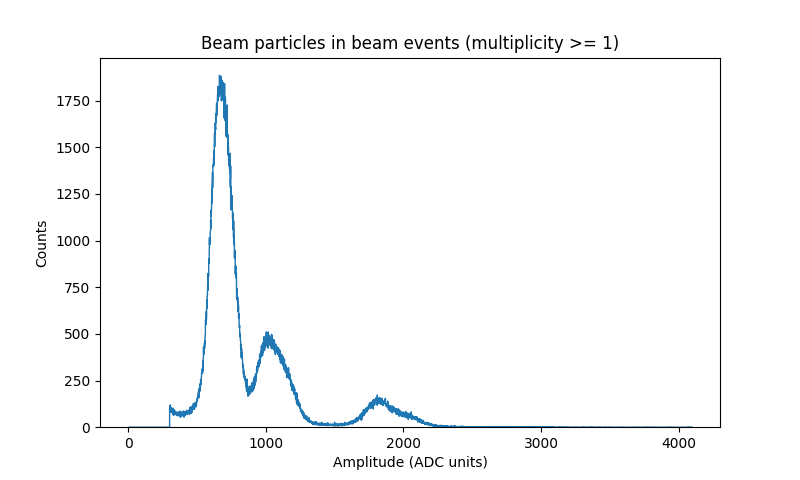

In [113]:
# Plot signal amplitude of beam particles in beam events
beam_events_ic = grammer.get_hist1d('beam_events_ic')
fig, ax = plt.subplots()
ax.stairs(beam_events_ic.counts, edges=beam_events_ic.bins)
ax.set_title('Beam particles in beam events (multiplicity >= 1)')
ax.set_xlabel('Amplitude (ADC units)')
ax.set_ylabel("Counts")
fig.set_figwidth(8.0)

In [114]:
# Calculate total number of beam particles of interest in analyzed runs
downscale_factor = 1000
beam_counts, _, _ = beam_events_ic.stats_for_range((450.0, 850.0))
beam_counts *= downscale_factor

print(beam_counts)

359621000


In [115]:
# Calculate cross section
length = max_z - min_z    # Units of meters
beam_spot_area = np.pi * (0.02**2)  # Units of meters^2
volume = beam_spot_area * length # Units of meters^2
beam_rate = beam_counts / beam_spot_area # Units of counts / meters^2 / time
target_nuclei = pressure * torr_2_pascal * volume / boltzmann / temperature # Number of nuclei in target seen by beam
print(target_nuclei)

2.5455581277759413e+22


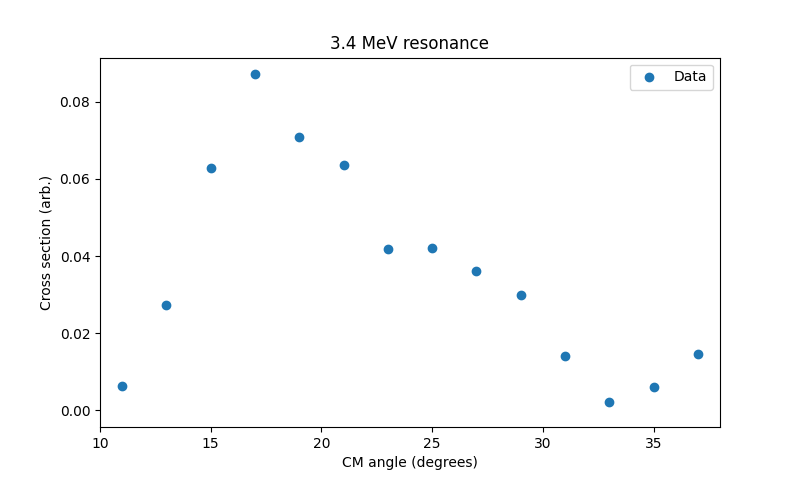

In [123]:
#Convert to arbitrary cross section
cm_hist = grammer.get_hist1d("cm_polar")
bins = cm_hist.bins
bin_width = cm_hist.bin_width

#arb_xs = cm_hist.counts / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / bin_width
xs = cm_hist.counts / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / bin_width / (2 * np.pi * beam_rate * target_nuclei) * 1.0e31
err = np.sqrt(cm_hist.counts) / np.sin(np.deg2rad(bins[:len(bins)-1]+bin_width/2)) / bin_width

# Ptolemy DWBA calculations
es3_l1 = pl.read_csv("D:\\ptolemy\\11Be\\3.4_mev\\l1\\beam_93mev.csv")
es3_l1_93 = es3_l1.to_dict(as_series=True)
es3_l2 = pl.read_csv("D:\\ptolemy\\11Be\\3.4_mev\\l2\\beam_93mev.csv")
es3_l2_93 = es3_l2.to_dict(as_series=True)

cm_hist = grammer.get_hist1d("cm_polar")
fig, ax = plt.subplots(1,1)
#ax.errorbar(bins[:len(bins)-1] + (bin_width / 2), xs, yerr=err, fmt='o', label="Data")
ax.scatter(bins[:len(bins)-1] + (bin_width / 2), xs, label="Data")
# ax.plot(es3_l1_93['cm_angle'],es3_l1_93['xs_mb']*14, label="es3_l1")
# ax.plot(es3_l2_93['cm_angle'],es3_l2_93['xs_mb']*7.5, label="es3_l2")

ax.set_title(f"{residual.get_latex_rep()} CM Scattering Angle")
ax.set_title("3.4 MeV resonance")
ax.set_xlabel("CM angle (degrees)")
ax.set_ylabel("Cross section (arb.)")
#ax.semilogy()
ax.legend()
plt.xlim(10,38)
#plt.ylim(0,20)
fig.set_figwidth(8.0)